<img src="https://hilpisch.com/tpq_logo_bic.png" width="20%" align="right">

# Python for Algorithmic Trading
## Event-Based Backtest: Daily Momentum

&copy; Dr. Yves J. Hilpisch<br>
AI-Powered by GPT 5.1<br>
The Python Quants GmbH | https://tpq.io<br>
https://hilpisch.com | https://linktr.ee/dyjh


## Notebook Goals

This notebook implements a minimal event-based backtest for a daily EURUSD momentum strategy as developed in Section 7 of the article. You will

- construct basic event types (`MarketEvent`, `SignalEvent`, `OrderEvent`, `FillEvent`),
- wire together data handler, strategy, portfolio, and execution components, and
- run an event loop that produces an equity curve comparable to the vectorized examples.


In [1]:
# Minimal event-based backtest for a daily momentum rule on a single instrument.

from collections import deque
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
plt.rcParams.update({"figure.dpi": 150})

DATA_PATH = Path("../data/epat_eod.csv")
DATA_URL = (
    "https://raw.githubusercontent.com/yhilpisch/epatcode/"
    "refs/heads/main/data/epat_eod.csv"
)
DATA_SRC = DATA_PATH if DATA_PATH.is_file() else DATA_URL
symbol = "EURUSD"  # default column to trade; change as needed


## 1. Event Types

We define a tiny set of event classes for market data, signals, orders, and fills. They carry just enough information to drive the backtest.

In [2]:
@dataclass
class MarketEvent:
    dt: pd.Timestamp
    price: float


@dataclass
class SignalEvent:
    dt: pd.Timestamp
    direction: int  # -1 (short) or +1 (long)


@dataclass
class OrderEvent:
    dt: pd.Timestamp
    direction: int  # -1 (sell/short) or +1 (buy/long)


@dataclass
class FillEvent:
    dt: pd.Timestamp
    direction: int
    price: float


## 2. Core Components

We next define four components: a data handler stepping through symbol prices, a momentum strategy, a simple portfolio that tracks position and equity, and a naive execution handler that fills orders at the current price.

In [96]:
class DataHandler:
    def __init__(self, prices: pd.Series):
        self.prices = prices
        self.iterator = iter(prices.items())
        self.continue_backtest = True

    def update_bars(self, events: deque) -> None:
        try:
            dt, price = next(self.iterator)
        except StopIteration:
            self.continue_backtest = False
            return
        events.append(MarketEvent(dt=dt, price=float(price)))


class MomentumStrategy:
    def __init__(self, threshold: float=0.0175):
        # only react to moves larger than this absolute log-return
        self.threshold = threshold
        self.last_price: float | None = None
        self.prices = list()

    def on_market(self, event: MarketEvent, events: deque) -> None:
        if self.last_price is None:
            self.last_price = event.price
            return
        self.prices.append(event.price)
        ret = np.log(event.price) - np.log(self.last_price)  # daily log-return
        if abs(ret) < self.threshold:
            # ignore very small moves to reduce unnecessary turnover
            self.last_price = event.price
            return
        direction = int(np.sign(ret))  # -1 for down move, +1 for up move
        ###
        # lags = 9  # number of lagged returns to calculate the "momentum"
        # if len(self.prices) > lags:
        #   pr = np.array(self.prices)
        #   rets = pr[-lags:] / pr[-lags-1:-1] - 1
        #   direction = int(np.sign(rets.mean()))
        ###
        events.append(SignalEvent(dt=event.dt, direction=direction))
        self.last_price = event.price


class SimplePortfolio:
    def __init__(self, cash: float=1.0):
        self.cash = cash
        self.position = 0  # signed number of units
        self.equity_history: list[float] = []
        self.dt_history: list[pd.Timestamp] = []
        self.last_price: float | None = None

    def mark_to_market(self, dt: pd.Timestamp, price: float) -> None:
        self.last_price = price
        equity = self.cash + self.position * price
        self.dt_history.append(dt)
        self.equity_history.append(equity)

    def on_signal(self, event: SignalEvent, events: deque) -> None:
        if event.direction == self.position:
            return  # already in desired direction
        events.append(OrderEvent(dt=event.dt, direction=event.direction))

    def on_fill(self, event: FillEvent) -> None:
        if self.last_price is None:
            return
        # compute trade quantity needed to reach target direction
        quantity = event.direction - self.position
        trade_value = quantity * self.last_price
        self.position += quantity
        self.cash -= trade_value


class NaiveExecutionHandler:
    def on_order(self, event: OrderEvent, events: deque, last_price: float) -> None:
        events.append(FillEvent(dt=event.dt, direction=event.direction, price=last_price))


## 3. Event Loop

The event loop pulls market events from the data handler, lets the strategy react, converts signals into orders and fills, and keeps the portfolio state in sync.

In [97]:
def run_backtest(prices: pd.Series) -> tuple[pd.DatetimeIndex, np.ndarray]:
    events: deque=deque()
    data = DataHandler(prices=prices)
    strat = MomentumStrategy()
    port = SimplePortfolio(cash=1.0)
    exec_handler = NaiveExecutionHandler()

    while data.continue_backtest:
        data.update_bars(events)  # push MarketEvent if available
        while events:
            event = events.popleft()
            if isinstance(event, MarketEvent):
                port.mark_to_market(event.dt, event.price)
                strat.on_market(event, events)
            elif isinstance(event, SignalEvent):
                port.on_signal(event, events)
            elif isinstance(event, OrderEvent):
                assert port.last_price is not None
                exec_handler.on_order(event, events, last_price=port.last_price)
            elif isinstance(event, FillEvent):
                port.on_fill(event)

    dates = pd.DatetimeIndex(port.dt_history)
    equity = np.array(port.equity_history)
    #print(strat.prices)
    return dates, equity


## 4. Run the Momentum Strategy

We now run the event-based backtest on daily prices for the chosen symbol and plot the resulting equity curve.

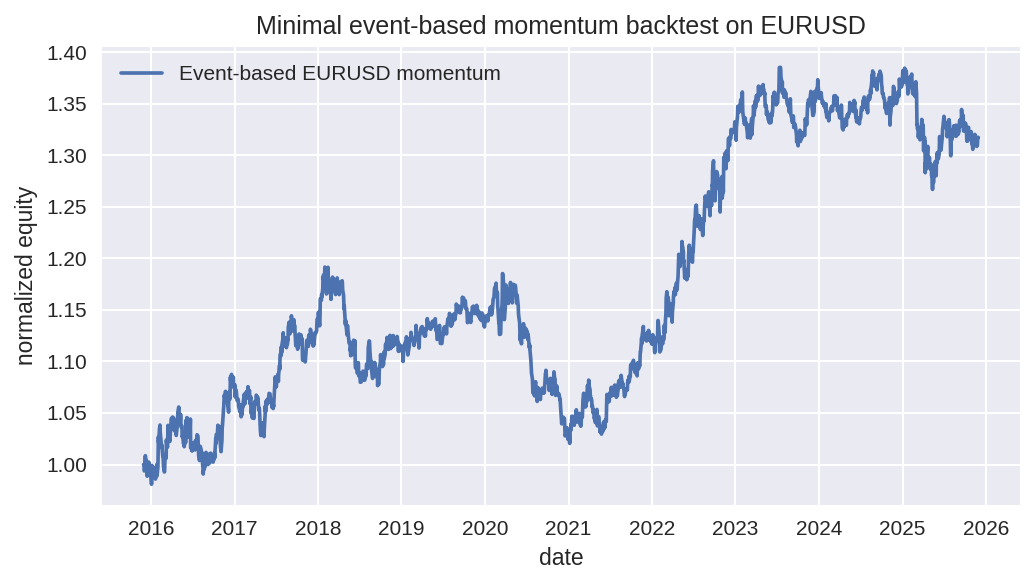

In [98]:
raw = pd.read_csv(DATA_SRC, parse_dates=["Date"]).set_index("Date").sort_index()
prices = raw[symbol].astype(float).dropna()

dates_ev, equity_ev = run_backtest(prices)
equity_norm = equity_ev / equity_ev[0]

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(dates_ev, equity_norm, label=f"Event-based {symbol} momentum")
ax.set_xlabel("date")
ax.set_ylabel("normalized equity")
ax.set_title(f"Minimal event-based momentum backtest on {symbol}")
ax.legend(loc="best")
fig.tight_layout()
plt.show()


## 5. Performance Metrics: Benchmark vs Momentum Strategy

To interpret the equity curve we compare basic performance metrics for a buy-and-hold position in the symbol and the event-based momentum strategy on exactly the same sample window. We use normalized equity curves to compute total return, maximum drawdown and its duration, and annualized return, volatility, and Sharpe ratio.

In [50]:
trading_days = 252  # rough number of trading days per year

def max_drawdown_and_duration(equity: np.ndarray) -> tuple[float, int]:
    """Compute maximum drawdown and its duration (in periods)."""

    peak = np.maximum.accumulate(equity)
    dd = equity / peak - 1.0  # drawdown series (<= 0)
    underwater = dd < 0.0
    max_dur = 0
    cur = 0
    for flag in underwater:
        if flag:
            cur += 1
            if cur > max_dur:
                max_dur = cur
        else:
            cur = 0
    return float(dd.min()), int(max_dur)


# benchmark equity (buy-and-hold) on the same dates
prices_eff = prices.loc[dates_ev]
eq_bh = prices_eff.to_numpy() / float(prices_eff.iloc[0])

# log-returns implied by equity curves
log_ret_bh = np.diff(np.log(eq_bh))
log_ret_strat = np.diff(np.log(equity_norm))

eq_bh_full = eq_bh
eq_strat_full = equity_norm

ann_ret_bh = log_ret_bh.mean() * trading_days
ann_vol_bh = log_ret_bh.std(ddof=1) * np.sqrt(trading_days)
sharpe_bh = ann_ret_bh / ann_vol_bh if ann_vol_bh > 0.0 else np.nan
total_ret_bh = eq_bh_full[-1] - 1.0
max_dd_bh, dur_bh = max_drawdown_and_duration(eq_bh_full)

ann_ret_strat = log_ret_strat.mean() * trading_days
ann_vol_strat = log_ret_strat.std(ddof=1) * np.sqrt(trading_days)
sharpe_strat = (ann_ret_strat / ann_vol_strat
                if ann_vol_strat > 0.0 else np.nan)
total_ret_strat = eq_strat_full[-1] - 1.0
max_dd_strat, dur_strat = max_drawdown_and_duration(eq_strat_full)

summary = pd.DataFrame(
    {
        "ann_return": [ann_ret_bh, ann_ret_strat],
        "ann_vol": [ann_vol_bh, ann_vol_strat],
        "sharpe": [sharpe_bh, sharpe_strat],
        "total_return": [total_ret_bh, total_ret_strat],
        "max_drawdown": [max_dd_bh, max_dd_strat],
        "dd_duration": [dur_bh, dur_strat],
    },
    index=["buy_and_hold", "event_momentum"],
)
summary.round(3).T


,buy_and_hold,event_momentum
ann_return,0.010,0.032
ann_vol,0.079,0.075
sharpe,0.126,0.421
total_return,0.091,0.317
max_drawdown,-0.233,-0.144
dd_duration,1767.000,917.000


## 6. Reflections and Extensions

This minimal engine already mirrors a simplified live-trading environment:

- the same event types could feed into a streaming data source,
- order-handling and cost models can be refined without changing the strategy code, and
- multiple instruments can be supported by extending `MarketEvent` and `SimplePortfolio`.

The article's later sections and the streaming notebook build directly on this structure.

<img src="https://hilpisch.com/tpq_logo_bic.png" width="20%" align="right">

Note.

The event-based momentum backtest shown here is also purely in-sample: the same price history drives signal generation and performance evaluation. A production-grade setup would introduce explicit out-of-sample periods or rolling evaluation windows to check whether the behaviour persists beyond the training sample.
